In [1]:
# Notebook settings
%load_ext autoreload
%autoreload 2
# %matplotlib notebook
%config Completer.use_jedi = False

# SpikeInterface pipeline for Movshon Lab - OpenEphys

In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

import spikeextractors as se
import spiketoolkit as st
import spikesorters as ss
import spikecomparison as sc
import spikewidgets as sw

## 1) Load recordings, compute LFP, and inspect signals

In [3]:
# Data files directory
dir_path = Path('/home/luiz/storage/taufferconsulting/client_ben/project_movshon/movshon_data/oephys')
dir_path = Path('/home/luiz/storage/taufferconsulting/client_ben/project_movshon/movshon_data/expo/exampledata/expo_openephys/m666l3#7/openephys')

# Spikeinterface directory
dir_spikeinterface = dir_path / "spikeinterface"
dir_spikeinterface.mkdir(parents=True, exist_ok=True)
print(dir_spikeinterface)

# Create recording extractor
recording = se.OpenEphysRecordingExtractor(folder_path=dir_path)

print(f"Num channels: {recording.get_num_channels()}")
print(f"Sampling rate: {recording.get_sampling_frequency()}")
print(f"Duration (s): {recording.get_num_frames() / recording.get_sampling_frequency()}")

/home/luiz/storage/taufferconsulting/client_ben/project_movshon/movshon_data/expo/exampledata/expo_openephys/m666l3#7/openephys/spikeinterface
Loading Open-Ephys: reading settings...
Decoding data from  openephys  format
Num channels: 32
Sampling rate: 30000.0
Duration (s): 177.22026666666667


### Compute LFP

In [4]:
freq_min_lfp = 1
freq_max_lfp = 300
freq_resample_lfp = 1000.

# Apply bandpass filter
recording_lfp = st.preprocessing.bandpass_filter(recording, freq_min=freq_min_lfp, freq_max=freq_max_lfp)

# Resample lfp
recording_lfp = st.preprocessing.resample(recording_lfp, freq_resample_lfp)

print(f"Sampling frequency Raw: {recording.get_sampling_frequency()}")
print(f"Sampling frequency LF: {recording_lfp.get_sampling_frequency()}")   

Sampling frequency Raw: 30000.0
Sampling frequency LF: 1000.0


### Inspect signals

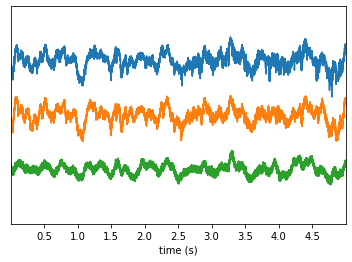

In [5]:
w_ts_raw = sw.plot_timeseries(recording, trange=[0, 5], channel_ids=[1, 2, 3])

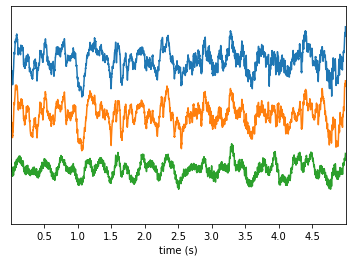

In [6]:
w_ts_lf = sw.plot_timeseries(recording_lfp, trange=[0, 5], channel_ids=[1, 2, 3])

## 2) Pre-processing

In [7]:
apply_filter = True
apply_cmr = True
freq_min_hp = 300
freq_max_hp = 3000

In [8]:
# Filtered recordings
if apply_filter:
    recording_processed = st.preprocessing.bandpass_filter(recording, freq_min=freq_min_hp, freq_max=freq_max_hp)
else:
    recording_processed = recording

if apply_cmr:
    recording_processed = st.preprocessing.common_reference(recording_processed)
    
# Stub recording for fast testing; set to False for running processing pipeline on entire data
stub_test = True
nsec_stub = 20
subr_ids = [i + 1 for i in range(10)]
if stub_test:
    recording_processed = se.SubRecordingExtractor(
        parent_recording=recording_processed, 
        channel_ids=subr_ids,
        end_frame=int(nsec_stub*recording_processed.get_sampling_frequency())
    )
    recording_lfp = se.SubRecordingExtractor(recording_lfp, end_frame=int(nsec_stub*recording_lfp.get_sampling_frequency()))
    
print(f"Original signal length: {recording.get_num_frames()}")
print(f"Processed signal length: {recording_processed.get_num_frames()}")

Original signal length: 5316608
Processed signal length: 600000


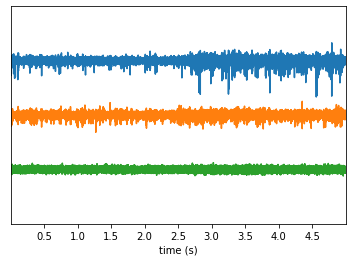

In [9]:
w_ts_processed = sw.plot_timeseries(recording_processed, trange=[0, 5], channel_ids=[1, 2, 3])

## 3) Run spike sorters

In [10]:
ss.installed_sorters()

['herdingspikes', 'klusta', 'spykingcircus']

In [11]:
sorter_list = ['klusta']

# Inspect sorter-specific parameters and defaults
for sorter in sorter_list:
    print(f"{sorter} params description:")
    pprint(ss.get_params_description(sorter))
    print("Default params:")
    pprint(ss.get_default_params(sorter))

klusta params description:
{'adjacency_radius': 'Radius in um to build channel neighborhood ',
 'chunk_mb': 'Chunk size in Mb for saving to binary format (default 500Mb)',
 'detect_sign': 'Use -1 (negative), 1 (positive) or 0 (both) depending on the '
                'sign of the spikes in the recording',
 'extract_s_after': 'Number of samples to cut out after the peak',
 'extract_s_before': 'Number of samples to cut out before the peak',
 'n_features_per_channel': 'Number of PCA features per channel',
 'n_jobs_bin': 'Number of jobs for saving to binary format (Default 1)',
 'num_starting_clusters': 'Number of initial clusters',
 'pca_n_waveforms_max': 'Maximum number of waveforms for PCA',
 'threshold_strong_std_factor': 'Strong threshold for spike detection',
 'threshold_weak_std_factor': 'Weak threshold for spike detection'}
Default params:
{'adjacency_radius': None,
 'chunk_mb': 500,
 'detect_sign': -1,
 'extract_s_after': 32,
 'extract_s_before': 16,
 'n_features_per_channel': 3,


In [12]:
# user-specific parameters
sorter_params = dict(
    klusta=dict()
)

In [13]:
# Choose which recording to use for sorting
rec_to_sort = recording_processed

# run sorting
sorting = ss.run_klusta(
    recording=rec_to_sort, 
    output_folder=dir_spikeinterface / "si_output"
)

WARNING! No channel location given. Add dummy location.
RUNNING SHELL SCRIPT: /home/luiz/storage/taufferconsulting/client_ben/project_movshon/movshon_data/expo/exampledata/expo_openephys/m666l3#7/openephys/spikeinterface/si_output/run_klusta.sh


## 4) Post-processing: extract waveforms, templates, quality metrics, extracellular features
Ref: https://spikeinterface.readthedocs.io/en/latest/modules/toolkit/plot_2_postprocessing.html

### Set postprocessing parameters

In [14]:
# Post-processing params
postprocessing_params = st.postprocessing.get_common_params()
pprint(postprocessing_params)

OrderedDict([('max_spikes_per_unit', 300),
             ('recompute_info', False),
             ('save_property_or_features', True),
             ('memmap', True),
             ('seed', 0),
             ('verbose', False),
             ('joblib_backend', 'loky')])


In [15]:
# (optional) change parameters
postprocessing_params['max_spikes_per_unit'] = 1000  # with None, all waveforms are extracted

### Set quality metric list

In [16]:
# Quality metrics
qc_list = st.validation.get_quality_metrics_list()
print(f"Available quality metrics: {qc_list}")

Available quality metrics: ['num_spikes', 'firing_rate', 'presence_ratio', 'isi_violation', 'amplitude_cutoff', 'snr', 'max_drift', 'cumulative_drift', 'silhouette_score', 'isolation_distance', 'l_ratio', 'd_prime', 'noise_overlap', 'nn_hit_rate', 'nn_miss_rate']


In [17]:
# (optional) define subset of qc
qc_list = ["snr", "isi_violation", "firing_rate"]

### Set extracellular features

In [18]:
# Extracellular features
ec_list = st.postprocessing.get_template_features_list()
print(f"Available EC features: {ec_list}")

Available EC features: ['peak_to_valley', 'halfwidth', 'peak_trough_ratio', 'repolarization_slope', 'recovery_slope']


In [19]:
# (optional) define subset of ec
ec_list = ["peak_to_valley", "halfwidth"]

### Postprocess all sorting outputs

In [20]:
# st.validation.compute_quality_metrics?

In [21]:
tmp_folder = dir_spikeinterface / 'tmp' / 'klusta'
tmp_folder.mkdir(parents=True, exist_ok=True)

# set local tmp folder
sorting.set_tmp_folder(tmp_folder)

# compute waveforms
waveforms = st.postprocessing.get_unit_waveforms(rec_to_sort, sorting, **postprocessing_params)

# compute templates
templates = st.postprocessing.get_unit_templates(rec_to_sort, sorting, **postprocessing_params)

# comput EC features
ec = st.postprocessing.compute_unit_template_features(rec_to_sort, sorting,
                                                      feature_names=ec_list, as_dataframe=True)
# compute QCs
qc = st.validation.compute_quality_metrics(sorting, recording=rec_to_sort, 
                                           metric_names=qc_list, as_dataframe=True)

# export to phy
phy_folder = dir_spikeinterface / 'phy' / 'klusta'
phy_folder.mkdir(parents=True, exist_ok=True)
st.postprocessing.export_to_phy(rec_to_sort, sorting, phy_folder)

Recomputing waveforms


Text(0, 0.5, 'Avg spike trace per channel')

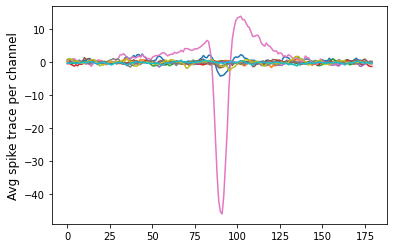

In [22]:
# Visualize spike template waverforms
unit_id = 1

plt.figure()
spk = np.squeeze(templates[unit_id])
plt.plot(spk.T)
plt.ylabel('Avg spike trace per channel', fontsize=12)

# 5) Automatic curation
Ref: https://spikeinterface.readthedocs.io/en/latest/modules/toolkit/plot_4_curation.html

In [23]:
# define curators and thresholds
firing_rate_threshold = 0.1
isi_violation_threshold = 0.5
snr_threshold = 5

In [24]:
num_frames = rec_to_sort.get_num_frames()

# firing rate threshold
sorting_curated = st.curation.threshold_firing_rates(
    sorting,
    duration_in_frames=num_frames,
    threshold=firing_rate_threshold, 
    threshold_sign='less'
)

# isi violation threshold
sorting_curated = st.curation.threshold_isi_violations(
    sorting,
    duration_in_frames=num_frames,
    threshold=isi_violation_threshold, 
    threshold_sign='greater'
)

# isi violation threshold
sorting_curated = st.curation.threshold_snrs(
    sorting,
    recording=rec_to_sort,
    threshold=snr_threshold, 
    threshold_sign='less'
)

In [25]:
print(f'Number of sorted units before curation: {len(sorting.get_unit_ids())}')
print(f'Number of sorted units after curation: {len(sorting_curated.get_unit_ids())}')

Number of sorted units before curation: 12
Number of sorted units after curation: 6


# 6) Quick save to NWB using Spikeinterface

In [26]:
output_nwb = 'openephys_si_results.nwb'

se.NwbRecordingExtractor.write_recording(
    recording=rec_to_sort,
    save_path=output_nwb,
    overwrite=True
)

se.NwbSortingExtractor.write_sorting(
    sorting=sorting,
    save_path=output_nwb,
    overwrite=False
)

/home/luiz/anaconda3/envs/env_movshon/lib/python3.6/site-packages/pynwb/file.py:753: UserWarning: Date is missing timezone information. Updating to local timezone.
  warn("Date is missing timezone information. Updating to local timezone.")
/media/luiz/storage/Github/spikeextractors/spikeextractors/extractors/nwbextractors/nwbextractors.py:1244: UserWarning: Description for property group not found in property_descriptions. Setting description to 'no description'
  f"Description for property {pr} not found in property_descriptions. "
/home/luiz/anaconda3/envs/env_movshon/lib/python3.6/site-packages/hdmf/build/objectmapper.py:256: DtypeConversionWarning: Spec 'Units/VectorData': Value with data type int64 is being converted to data type uint64 (min specification: uint8).
  warnings.warn(full_warning_msg, DtypeConversionWarning)


In [27]:
# Check NWB file with widgets
from pynwb import NWBFile, NWBHDF5IO
from nwbwidgets import nwb2widget

io = NWBHDF5IO(output_nwb, 'r')
nwbfile = io.read()
nwb2widget(nwbfile)